# Notebook 20 - Rank Recipes with Boosting

## Purpose
This notebook ranks recipes per store based on deployability. We enhance the scoring pipeline with semantic similarity between ingredients and products, priority-based boosting from waste/markdown signals, and strict filtering thresholds. The result is a curated list of high-quality recipe candidates per store for meal kit deployment.

## Objectives
- Join filtered matches with recipe context
- Boost match scores based on semantic and priority signals
- Filter out incomplete or weak matches
- Tag underperforming stores for exclusion
- Visualize distribution of deployable quality across the chain

## Inputs
- `matching_matrix_scored.csv` - Initial filtered fuzzy matches
- `recipes_with_variants.csv` - Recipe-ingredient metadata with embeddings
- `products_with_variants.csv` - Product data with embeddings and waste/markdown flags

## Outputs
- `recipe_store_ranked.csv` - Ranked recipe-store candidates with boosted scores
- Console diagnostics and barplot for store performance


In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Paths
input_folder = "matching_scored"
variant_folder = "variant_exports"
output_folder = "recipe_ranking"
os.makedirs(output_folder, exist_ok=True)

# File paths
match_file = os.path.join(input_folder, "matching_matrix_scored.csv")
recipes_file = os.path.join(variant_folder, "recipes_with_variants.csv")
products_file = os.path.join(variant_folder, "products_with_variants.csv")

# Load data
df_matches = pd.read_csv(match_file)
df_recipes = pd.read_csv(recipes_file)
df_products = pd.read_csv(products_file)

print("Loaded:")
print(f"- Matches: {df_matches.shape}")
print(f"- Recipes: {df_recipes.shape}")
print(f"- Products: {df_products.shape}")


C:\Users\User\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (1,3,5,31,36) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Loaded:
- Matches: (8, 10)
- Recipes: (6, 8)
- Products: (126919, 37)


In [9]:
# Ensure unique row ID for merging
if "row_id" not in df_recipes.columns:
    df_recipes = df_recipes.reset_index(drop=False).rename(columns={"index": "row_id"})


In [11]:
# Convert product_article to consistent type
df_matches["product_article"] = df_matches["product_article"].astype(str)
df_priority["product_article"] = df_priority["product_article"].astype(str)

# Merge product embedding and priority flags
df_full = df_matches.merge(df_context, on=["row_id", "ingredient"], how="left")
df_full = df_full.merge(df_priority, on="product_article", how="left")

print("Full enriched match table:", df_full.shape)
df_full.head()


Full enriched match table: (214, 15)


,row_id,ingredient,match_term,match_type_recipe,product_article,product_name,match_type_product,store,match_source,fuzzy_score,recipe,ingredient_embedding,product_embedding,waste_flag,markdown_flag
0,2,yogurt,yogurt,concept,438226,roeryoghurt,concept,1024.0,exact,71,Greek Yogurt & Honey,[-1.28770307e-01 -5.76514006e-01 2.47815490e-...,[ 2.26917386e-01 8.17842185e-02 2.35426668e-...,0,0
1,2,yogurt,yogurt,concept,438226,roeryoghurt,concept,1024.0,exact,71,Greek Yogurt & Honey,[-1.28770307e-01 -5.76514006e-01 2.47815490e-...,[-3.27512883e-02 3.62754874e-02 2.99213100e-...,1,0
2,2,yogurt,yogurt,concept,438226,roeryoghurt,concept,1024.0,exact,71,Greek Yogurt & Honey,[-1.28770307e-01 -5.76514006e-01 2.47815490e-...,[ 2.26917386e-01 8.17842185e-02 2.35426668e-...,0,0
3,2,yogurt,yogurt,concept,438226,roeryoghurt,concept,1024.0,exact,71,Greek Yogurt & Honey,[-1.28770307e-01 -5.76514006e-01 2.47815490e-...,[ 2.26917386e-01 8.17842185e-02 2.35426668e-...,0,0
4,2,yogurt,yogurt,concept,438226,roeryoghurt,concept,1024.0,exact,71,Greek Yogurt & Honey,[-1.28770307e-01 -5.76514006e-01 2.47815490e-...,[ 2.26917386e-01 8.17842185e-02 2.35426668e-...,0,0


In [12]:
# Compute cosine similarity between ingredient and product embeddings
def compute_semantic_similarity(row):
    try:
        emb_ingredient = np.array(eval(row["ingredient_embedding"]))
        emb_product = np.array(eval(row["product_embedding"]))
        sim = cosine_similarity([emb_ingredient], [emb_product])[0][0]
        return sim
    except:
        return np.nan

df_full["semantic_score"] = df_full.apply(compute_semantic_similarity, axis=1)
df_full["semantic_score"] = df_full["semantic_score"].fillna(0)

print("Semantic similarity computed.")
df_full[["ingredient", "product_name", "fuzzy_score", "semantic_score"]].head()


Semantic similarity computed.


,ingredient,product_name,fuzzy_score,semantic_score
0,yogurt,roeryoghurt,71,0.0
1,yogurt,roeryoghurt,71,0.0
2,yogurt,roeryoghurt,71,0.0
3,yogurt,roeryoghurt,71,0.0
4,yogurt,roeryoghurt,71,0.0


In [13]:
# Priority boosting weights
WEIGHT_FUZZY = 0.6
WEIGHT_SEMANTIC = 0.4
PRIORITY_BONUS = 5  # additive

# Compute final boosted score
df_full["final_score"] = (
    WEIGHT_FUZZY * df_full["fuzzy_score"] +
    WEIGHT_SEMANTIC * 100 * df_full["semantic_score"] +
    PRIORITY_BONUS * (df_full["waste_flag"] + df_full["markdown_flag"])
)

df_full["final_score"] = df_full["final_score"].round(2)
print("Boosted score calculated.")


Boosted score calculated.


In [14]:
# Count how many ingredients are needed per recipe
df_total_ingredients = df_recipes.groupby("recipe")["ingredient"].nunique().reset_index()
df_total_ingredients = df_total_ingredients.rename(columns={"ingredient": "n_ingredients"})

# Count matched ingredients per (store, recipe)
df_agg = (
    df_full.groupby(["store", "recipe"])
    .agg(
        matched_ingredients=("ingredient", "nunique"),
        avg_score=("final_score", "mean")
    )
    .reset_index()
)

# Join total ingredient counts
df_agg = df_agg.merge(df_total_ingredients, on="recipe", how="left")
df_agg["coverage"] = df_agg["matched_ingredients"] / df_agg["n_ingredients"]


In [19]:
# Filter to complete recipes and high quality only
min_avg_score = 40
df_ranked = df_agg[(df_agg["coverage"] == 1.0) & (df_agg["avg_score"] >= min_avg_score)].copy()

# Sort
df_ranked = df_ranked.sort_values(["store", "avg_score"], ascending=[True, False]).reset_index(drop=True)

# Save
output_file = os.path.join(output_folder, "recipe_store_ranked.csv")
df_ranked.to_csv(output_file, index=False)

print(f"Saved boosted ranking to: {output_file}")


Saved boosted ranking to: recipe_ranking\recipe_store_ranked.csv


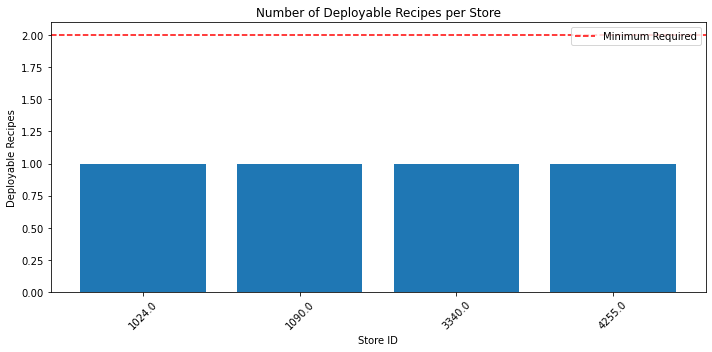

Underperforming stores tagged:
    store  n_recipes  underperforming
0  1024.0          1             True
1  1090.0          1             True
2  3340.0          1             True
3  4255.0          1             True


In [20]:
# Store performance summary
recipe_counts = df_ranked.groupby("store")["recipe"].nunique().reset_index(name="n_recipes")

# Flag underperformers
min_recipes = 2
recipe_counts["underperforming"] = recipe_counts["n_recipes"] < min_recipes

# Plot
plt.figure(figsize=(10, 5))
plt.bar(recipe_counts["store"].astype(str), recipe_counts["n_recipes"])
plt.axhline(min_recipes, color="red", linestyle="--", label="Minimum Required")
plt.title("Number of Deployable Recipes per Store")
plt.xlabel("Store ID")
plt.ylabel("Deployable Recipes")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

print("Underperforming stores tagged:")
print(recipe_counts[recipe_counts["underperforming"] == True])


In [21]:
# Save full semantic + priority enriched match matrix
semantic_output_file = os.path.join("matching_scored", "matching_matrix_semantic.csv")
df_full.to_csv(semantic_output_file, index=False)
print(f"Saved semantic match matrix to: {semantic_output_file}")


Saved semantic match matrix to: matching_scored\matching_matrix_semantic.csv
